# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [4]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
    Replace,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    OrdinalEncoder, 
    WOEEncoder,
    OneHotEncoder
)
# binning
from gators.binning import (
    BinRareCategories,
    Binning,
    CustomBinning,
    QuantileBinning,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    PolynomialFeatures,
    ElementaryArithmetics,
    PolynomialObjectFeatures,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
    InformationValue
)
# model building
from gators.model_building import (
    TrainTestSplit,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

### with pandas

In [5]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
# train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
# X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [6]:
X.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


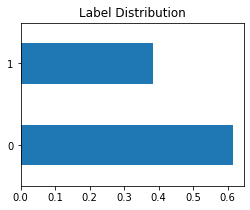

In [7]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(4, 3), 
    title='Label Distribution',
);

### offline pipeline - data preprocessing & feature selection

In [8]:
k = 15
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
steps = [
    ('SplitExtractDummy', SplitExtract(
        columns=['Name'], str_split_vec=[', '], idx_split_vec=[1], column_names=['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('StringLength', StringLength(columns=['Ticket', 'Cabin'])),
    ('DropColumns1', DropColumns(['Ticket', 'Cabin', 'Name', 'Dummy'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('Replace', Replace(to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}})),
    ('FloatImputer', NumericsImputer(columns=['Age', 'Fare'], strategy='mean', value=-9.)),
    ('IntImputer', NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent', value=-9.)),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'],
        columns_b=['Parch'], 
        column_names=['FamilitySize'])),
    ('DropColumns2', DropColumns(columns=['SibSp'])),
    ('TreeBinning', TreeBinning(tree, inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilitySize'],
        degree=2)),
    ('BinRareCategories', BinRareCategories(min_ratio=0.)),
    ('WOEEncoder', WOEEncoder()),
    ('Classifier', XGBClassifier(random_state=0))
]
pipe = Pipeline(steps=steps)

In [9]:
param_grid = {
    "ObjectImputer__strategy": ["most_frequent", "constant"],
    "TreeBinning__tree": [
        DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, random_state=0),
        DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=0),
    ],
    "PolynomialObjectFeatures__degree": [2, 3],
}
cv = RepeatedStratifiedKFold(random_state=0)
# cv = StratifiedKFold()
search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)
_ = search.fit(X.copy(), y)
print(f"Best parameter (CV score={round(search.best_score_, 3)}):")
print(search.best_params_)

Fitting 50 folds for each of 8 candidates, totalling 400 fits
Best parameter (CV score=0.824):
{'ObjectImputer__strategy': 'constant', 'PolynomialObjectFeatures__degree': 2, 'TreeBinning__tree': DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=0)}


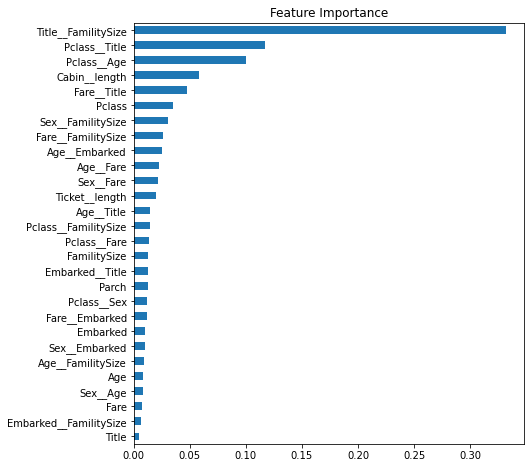

In [10]:
# search.best_estimator_.steps[-1][1].feature_importances_
feature_importances_ = search.best_estimator_.steps[-1][1].feature_importances_
index = search.best_estimator_.steps[-2][1].columns_
feature_importances_pd = pd.Series(feature_importances_, index=index).sort_values()
feature_importances_pd = feature_importances_pd[feature_importances_pd != 0]

feature_importances_pd.plot(
    kind='barh', 
    figsize=(7, len(index) / 4), 
    title='Feature Importance',
);
features = list(feature_importances_pd.index)

In [11]:
k = 15
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=0)
steps = [
    ('SplitExtractDummy', SplitExtract(
        columns=['Name'], str_split_vec=[', '], idx_split_vec=[1], column_names=['Dummy'])),
    ('SplitExtractTitle', SplitExtract(['Dummy'], ['.'], [0], ['Title'])),
    ('StringLength', StringLength(columns=['Ticket', 'Cabin'])),
    ('DropColumns1', DropColumns(['Ticket', 'Cabin', 'Name', 'Dummy'])),
    ('ObjectImputer', ObjectImputer(strategy='constant', value='MISSING')),
    ('Replace', Replace(to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}})),
    ('FloatImputer', NumericsImputer(strategy='mean')),
    ('ElementaryArithmetics', ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'],
        columns_b=['Parch'], 
        column_names=['FamilitySize'])),
    ('DropColumns2', DropColumns(columns=['SibSp', 'Parch'])),
    ('TreeBinning', TreeBinning(tree, inplace=True)),
    ('PolynomialObjectFeatures', PolynomialObjectFeatures(
        columns=['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilitySize'],
        degree=2)),
    ('BinRareCategories', BinRareCategories(min_ratio=0.)),
    ('WOEEncoder', WOEEncoder()),
]
pipe = Pipeline(steps=steps)
X_prepro = pipe.fit_transform(X.copy(), y)

In [12]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [1, 1.5, 2, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'min_child_weight': [2, 5]
        }
    
cv = RepeatedStratifiedKFold(random_state=0)
# cv = StratifiedKFold()
search = RandomizedSearchCV(
    model, n_iter=20, param_distributions=params, cv=cv, n_jobs=-1, 
    verbose=1, random_state=0)
_ = search.fit(X_prepro, y)
print(f"Best parameter (CV score={round(search.best_score_, 3)}):")
print(search.best_params_)

Fitting 50 folds for each of 20 candidates, totalling 1000 fits
Best parameter (CV score=0.845):
{'subsample': 0.4, 'min_child_weight': 2, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}


In [13]:
test = pd.read_csv('../../../Downloads/test.csv', index_col=0)
test = pipe.transform(test)

In [14]:
y_test = search.predict(test)

In [38]:
z = 0.5*search.predict(test)+0.3*rf.predict(test)+0.2 * lr.predict(test)

In [40]:
StackingSubmission = pd.DataFrame({ 'PassengerId': test.index,
                            'Survived': (z > 0.5).astype(int) })
StackingSubmission.to_csv("StackingSubmission1.csv", index=False)

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
rf = RandomForestClassifier(random_state=0)
lr = LogisticRegression(random_state=0)

In [18]:
rf.fit(X_prepro, y)

RandomForestClassifier(random_state=0)

In [19]:
lr.fit(X_prepro, y)
(y == lr.predict(X_prepro)).mean()

0.8641975308641975

In [20]:
params = {
        'C': np.logspace(-3, 3, 50),
        }
    
cv = RepeatedStratifiedKFold(random_state=0)
# cv = StratifiedKFold()
search = RandomizedSearchCV(
    lr, n_iter=20, param_distributions=params, cv=cv, n_jobs=-1, 
    verbose=1, random_state=0)
_ = search.fit(X_prepro, y)
print(f"Best parameter (CV score={round(search.best_score_, 3)}):")
print(search.best_params_)

Fitting 50 folds for each of 20 candidates, totalling 1000 fits
Best parameter (CV score=0.858):
{'C': 0.15998587196060574}


In [21]:
params = {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 4, 5],
        }
    
cv = RepeatedStratifiedKFold(random_state=0)
# cv = StratifiedKFold()
search = RandomizedSearchCV(
    rf, n_iter=20, param_distributions=params, cv=cv, n_jobs=-1, 
    verbose=1, random_state=0)
_ = search.fit(X_prepro, y)
print(f"Best parameter (CV score={round(search.best_score_, 3)}):")
print(search.best_params_)

Fitting 50 folds for each of 9 candidates, totalling 450 fits
Best parameter (CV score=0.844):
{'n_estimators': 150, 'max_depth': 5}


In [22]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score').columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_depth', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'split10_test_score', 'split11_test_score', 'split12_test_score',
       'split13_test_score', 'split14_test_score', 'split15_test_score',
       'split16_test_score', 'split17_test_score', 'split18_test_score',
       'split19_test_score', 'split20_test_score', 'split21_test_score',
       'split22_test_score', 'split23_test_score', 'split24_test_score',
       'split25_test_score', 'split26_test_score', 'split27_test_score',
       'split28_test_score', 'split29_test_score', 'split30_test_score',
       'split31_test_score', 'split32_test_score', 'split33_test_score',
       'split34_test_score', 'split35_test_score',

In [23]:
list(pd.DataFrame(search.cv_results_)[['mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').iloc[0])

[0.8439940995543281, 0.021391408304685295, 1.0]

In [24]:
list(pd.DataFrame(search.cv_results_)[['mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').iloc[0])

[0.8439940995543281, 0.021391408304685295, 1.0]

In [25]:
list(pd.DataFrame(search.cv_results_).sort_values('rank_test_score').iloc[0])

[0.47638903141021727,
 0.024488004584987486,
 0.03945629119873047,
 0.006408437557181303,
 150,
 5,
 {'n_estimators': 150, 'max_depth': 5},
 0.8547486033519553,
 0.8707865168539326,
 0.8651685393258427,
 0.8146067415730337,
 0.8033707865168539,
 0.8212290502793296,
 0.8426966292134831,
 0.8595505617977528,
 0.8202247191011236,
 0.8651685393258427,
 0.8603351955307262,
 0.8707865168539326,
 0.8314606741573034,
 0.8426966292134831,
 0.848314606741573,
 0.8268156424581006,
 0.8202247191011236,
 0.8539325842696629,
 0.848314606741573,
 0.8707865168539326,
 0.8491620111731844,
 0.8595505617977528,
 0.8595505617977528,
 0.8089887640449438,
 0.8146067415730337,
 0.8379888268156425,
 0.8651685393258427,
 0.8595505617977528,
 0.8314606741573034,
 0.8314606741573034,
 0.8715083798882681,
 0.8426966292134831,
 0.8370786516853933,
 0.8089887640449438,
 0.8651685393258427,
 0.8044692737430168,
 0.8089887640449438,
 0.8651685393258427,
 0.8932584269662921,
 0.848314606741573,
 0.8547486033519553,
 0

In [26]:
dir(search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'multim

In [32]:
z = 0.5*search.predict(X_prepro)+0.3*rf.predict(X_prepro)+0.2 * lr.predict(X_prepro)
(y == (z > 0.5)).mean()

0.8832772166105499

In [30]:
(y ==search.predict(X_prepro)).mean()

0.8709315375982043

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,

## production pipeline

In [28]:
list(set([c for col in X_train_prepro.columns for c in col.split('__')]))

NameError: name 'X_train_prepro' is not defined

In [ ]:
prod_steps = offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Name', 'Dummy']),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Fare', 'Age'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilitySize']),
    TreeBinning(max_depth=2, inplace=True),
    PolynomialObjectFeatures(
        columns=['Sex', 'Fare', 'Age', 'Embarked', 'Pclass', 'Title', 'FamilitySize'],
        degree=2),
    KeepColumns(columns_to_keep=[
        'Pclass__Sex', 'Pclass__Title', 'Sex__Fare', 'Sex__Embarked',
       'Sex__Title', 'Sex__FamilitySize', 'Fare__Title', 'Embarked__Title',
       'Title__FamilitySize']),
    BinRareCategories(min_ratio=1.),
    WOEEncoder(),
]

### pandas

In [ ]:
X_train_prod = X_train
X_train_prod_np = X_train_prod.to_numpy()
prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro


In [ ]:
X_train_prod = X_train
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

In [ ]:
X_train_prod_prepro

### koalas

In [ ]:
X_train_prod_ks = X_train_ks[prod_columns]
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

#### check pandas and koalas results match - production pipeline

In [ ]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)


## model building

### numpy

In [ ]:
def f1_score(y_true, y_pred):
    p = y_true[y_pred == 1].mean()
    r = y_pred[y_true == 1].mean()
    if (p == 0) | (r == 0):
        return 0
    return 2 * p * r / (p + r)
f1_scoring = make_scorer(f1_score)

y_train_np = y_train.to_numpy()
n_splits = 10
max_evals = 10
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 25),
    'max_depth': hp.quniform('max_depth', 2, 3, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1),
 }
model = XGBClassifier(
    random_state=0, 
    use_label_encoder=False,
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring=f1_scoring,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

In [ ]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [ ]:
hyper.history.sort_values('loss')

In [ ]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_titanic.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [ ]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [ ]:
xgb_booster = XGBBoosterBuilder.train(
    model=hyper.model, 
    X_train=X_train_prod_prepro_np, 
    y_train=y_train_np,
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_tl = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

#### check the models prediction match

In [ ]:
X_test_prod

In [ ]:
X_test_prod_np

In [ ]:
prod_pipe.transform(X_test_prod)[:, 1]

In [ ]:
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()
y_pred_pd = model_pd.predict_proba(
    prod_pipe.transform(X_test_prod))[:, 1]
y_pred_np = model.predict_proba(
    prod_pipe.transform_numpy(X_test_prod_np.copy()))[:, 1]
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_test_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [ ]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred):.2f}'

## per-sample bechmarking

### pipeline only

In [ ]:
x = X_test_prod.iloc[[0]]
x_np = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(x_np.copy())

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

### pipeline & model

In [ ]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(x_np.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(x_np.copy())))

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'